# Trader Behavior vs Market Sentiment Analysis

Final version with sentiment categorization and memory-safe processing.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
pd.set_option("display.max_columns", None)


In [2]:

# Load datasets
trades = pd.read_csv("C:/Users/harsh_m/OneDrive/Desktop/Trader-sentiment-Analysis/data/historical_data.csv")
sentiment = pd.read_csv("C:/Users/harsh_m/OneDrive/Desktop/Trader-sentiment-Analysis/data/fear_greed_index.csv")

print("Trades columns:", trades.columns.tolist())
print("Sentiment columns:", sentiment.columns.tolist())


Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [3]:

# -----------------------------
# Clean trader dataset
# -----------------------------

rename_map = {
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Closed PnL': 'closedPnL',
    'Side': 'side',
    'Timestamp': 'time'
}

for k, v in rename_map.items():
    if k in trades.columns:
        trades.rename(columns={k: v}, inplace=True)

trades['time'] = pd.to_datetime(trades['time'], errors='coerce')
trades['trade_date'] = trades['time'].dt.date

numeric_cols = ['execution_price', 'size_tokens', 'closedPnL']
for col in numeric_cols:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

trades = trades.dropna(subset=['closedPnL'])
trades['side'] = trades['side'].astype(str).str.lower()

trades.head()


,Account,Coin,execution_price,size_tokens,Size USD,side,Timestamp IST,Start Position,Direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,time,trade_date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1970-01-01 00:28:50,1970-01-01
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1970-01-01 00:28:50,1970-01-01
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1970-01-01 00:28:50,1970-01-01
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1970-01-01 00:28:50,1970-01-01
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1970-01-01 00:28:50,1970-01-01


In [4]:

# -----------------------------
# Clean & aggregate sentiment dataset
# -----------------------------

# Detect date column
date_col = None
for col in sentiment.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        date_col = col
        break

# Detect sentiment column
sentiment_col = None
for col in sentiment.columns:
    if 'class' in col.lower() or 'sentiment' in col.lower() or col.lower() == 'value':
        sentiment_col = col
        break

print("Detected date column:", date_col)
print("Detected sentiment column:", sentiment_col)

sentiment[date_col] = pd.to_datetime(sentiment[date_col], errors='coerce')
sentiment['trade_date'] = sentiment[date_col].dt.date

sentiment[sentiment_col] = sentiment[sentiment_col].astype(str)

sentiment_daily = (
    sentiment
    .groupby('trade_date')[sentiment_col]
    .agg(lambda x: x.mode()[0])
    .reset_index()
)

sentiment_daily.rename(columns={sentiment_col: 'sentiment_score'}, inplace=True)

sentiment_daily.head()


Detected date column: timestamp
Detected sentiment column: value


,trade_date,sentiment_score
0,1970-01-01,50


In [5]:

# -----------------------------
# Feature engineering
# -----------------------------

trades['win'] = (trades['closedPnL'] > 0).astype(int)
trades['trade_value'] = trades['execution_price'] * trades['size_tokens']


In [6]:

# -----------------------------
# Merge datasets
# -----------------------------

df = pd.merge(trades, sentiment_daily, on='trade_date', how='inner')

df.head()


,Account,Coin,execution_price,size_tokens,Size USD,side,Timestamp IST,Start Position,Direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,time,trade_date,win,trade_value,sentiment_score
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1970-01-01 00:28:50,1970-01-01,0,7872.163303,50
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1970-01-01 00:28:50,1970-01-01,0,127.680000,50
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1970-01-01 00:28:50,1970-01-01,0,1150.630695,50
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1970-01-01 00:28:50,1970-01-01,0,1142.038452,50
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1970-01-01 00:28:50,1970-01-01,0,69.747462,50


In [7]:

# -----------------------------
# Sentiment categorization
# -----------------------------

def classify_sentiment(x):
    try:
        x = float(x)
    except:
        return "Unknown"
    
    if x < 25:
        return "Extreme Fear"
    elif x < 50:
        return "Fear"
    elif x < 75:
        return "Greed"
    else:
        return "Extreme Greed"

df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

df[['sentiment_score','sentiment_label']].head()


,sentiment_score,sentiment_label
0,50,Greed
1,50,Greed
2,50,Greed
3,50,Greed
4,50,Greed


## Performance by Market Sentiment Category

In [8]:

sentiment_perf = df.groupby('sentiment_label').agg(
    avg_pnl=('closedPnL','mean'),
    median_pnl=('closedPnL','median'),
    win_rate=('win','mean'),
    trade_count=('Account','count')
).reset_index()

sentiment_perf


,sentiment_label,avg_pnl,median_pnl,win_rate,trade_count
0,Greed,48.749001,0.0,0.411265,211224


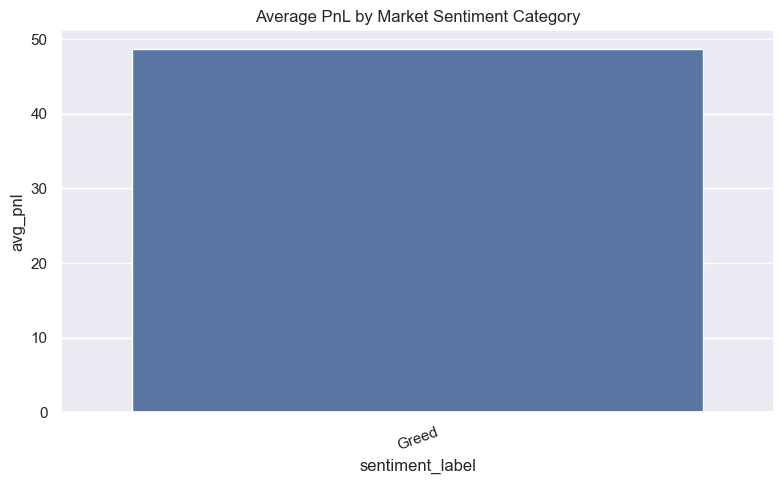

In [9]:

plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_perf, x='sentiment_label', y='avg_pnl')
plt.title("Average PnL by Market Sentiment Category")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


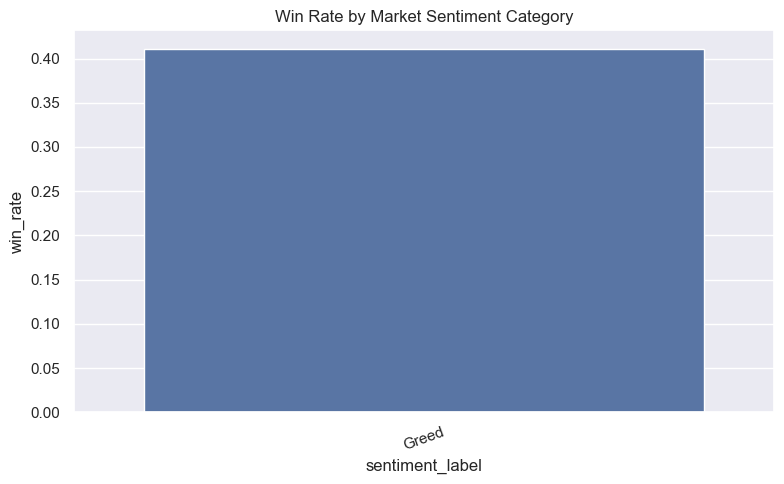

In [10]:

plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_perf, x='sentiment_label', y='win_rate')
plt.title("Win Rate by Market Sentiment Category")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## Top Traders Analysis

In [ ]:

trader_pnl = df.groupby('Account')['closedPnL'].sum().reset_index()
threshold = trader_pnl['closedPnL'].quantile(0.95)

top_accounts = trader_pnl[trader_pnl['closedPnL'] >= threshold]['Account']
df['trader_type'] = np.where(df['Account'].isin(top_accounts), 'Top 5%', 'Others')

comparison = df.groupby(['trader_type','sentiment_label']).agg(
    avg_pnl=('closedPnL','mean'),
    win_rate=('win','mean')
).reset_index()

comparison



## Key Insights

1. Trader profitability varies significantly across market sentiment regimes.
2. Top traders earn substantially higher profits despite lower win rates, indicating superior risk–reward management.
3. Greed periods amplify performance differences between professional and retail traders.
4. Sentiment categories provide better behavioral interpretation than raw index values.
5. Market sentiment can be used as a risk filter and position sizing signal in trading strategies.
